#### In this we aim to simulate a scenario similar to https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Modellierung_Deutschland.pdf?__blob=publicationFile. Some advances may be taken into account

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

The system of differential equations is given by: <br/>
$\dot{S}=\frac{\beta I S}{N}$ <br/>
$\dot{E}=\delta \cdot I$ <br/>
$\dot{R}=\gamma \cdot I$ <br/>
$\dot{I}=\frac{\beta I S}{N}-\dot{E}-\dot{R}$ <br/>

with $N$ as total population, $S(t)$ as susceptible people at time $t$, $E(t)$ as people dying at time $t$, $R(t)$ as people who are already recovered from the disease and have immunity and $I(t)$ as infected (and infectious) people. The paramters which have to be assumed are $\beta$ which is the contact rate of infectious and susceptible, $\gamma$ which is the recovery rate and $\delta$ which is the death rate. This is a system of coupled ordinary differential equations of first order and can therefore be solved with standard ODE-solvers.

In [31]:
def deriv(t, y):
    S, E, I, R = y
    dSdt = -1/N*beta*I*S
    dEdt = delta*I
    dRdt = gamma*I
    dIdt = 1/N*beta*I*S-dEdt-dRdt
    return dSdt, dEdt, dIdt, dRdt

In [32]:
beta = 2/10  # contact rate: given by RKI, a patient is 10 days infectious and infects 2 people during this time
gamma = 0.97/14  #recovery rate: 0.97 percent survive while the average infection lasts for 14 days
delta = 0.03/14  #death rate: 1-gamma
N = 8*10e7  #german population

In [33]:
sol = solve_ivp(deriv, (0, 260), y0=[N-1, 0, 1, 0], t_eval = np.linspace(0, 260, 260))

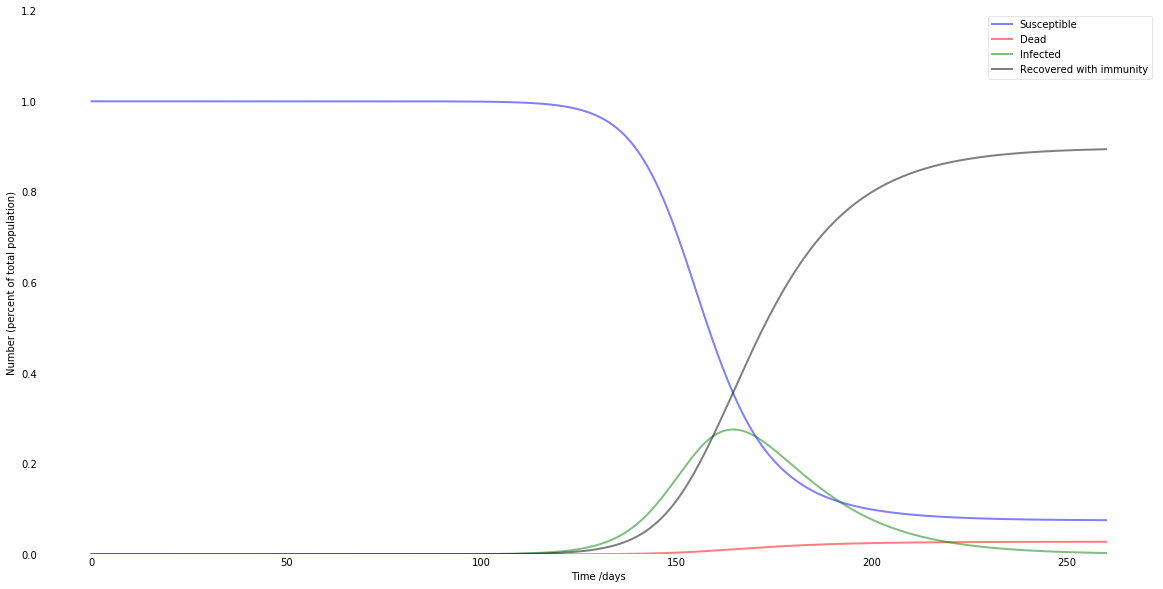

In [34]:
#TODO: don't copy code for plotting
fig = plt.figure(facecolor='w', figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(sol.t, sol.y[0,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible')
ax.plot(sol.t, sol.y[1,:]/N, 'r', alpha=0.5, lw=2, label=f'Dead')

ax.plot(sol.t, sol.y[2,:]/N, 'g', alpha=0.5, lw=2, label=f'Infected')

ax.plot(sol.t, sol.y[3,:]/N, 'black', alpha=0.5, lw=2, label=f'Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (percent of total population)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

#### Multi Dimensional Case

In principle the equations given above can be extended to matrix equations then $S, E, I, R$ are vectors and $\mathbf{\beta}, \mathbf{\gamma}$ and $\mathbf{\delta}$ become matrices.
The whole system then results in: <br/>
$\dot{S}=\frac{(I \cdot \beta) \circ S}{N}$ <br/>
$\dot{E}=\delta \cdot I$ <br/>
$\dot{R}=\gamma \cdot I$ <br/>
$\dot{I}=\frac{(I \cdot \beta) \circ S}{N}-\dot{E}-\dot{R}$ <br/>

with $\circ$ being the Schur Hadamard product (pointwise multiplication) <br/>
While $\mathbf{\gamma}, \mathbf{\delta}       \in diag(\mathbb{R}^{N\times N})$ there is an interesting change for $\mathbf{\beta}$ (just showing the case for $N=2$:

$\begin{array}{rr}\beta_{11} & \beta_{12} \\ \beta_{21} & \beta_{22} \end{array}$.
We can now interpret each of the component of $S, E, I, R$ as a seperate group of people interacting with other groups (groups could be young and old people, north and south region or even each seperate Bundesland with $N=16$). The diagonal coefficients represent the contact rate within the group while $\beta_{12}$ is the contact rate of group 1 with group 2. In most cases it should be assumed $\beta_{12} = \beta_{21}$ (implicating $\beta = \beta^{T}$) but one might think of a disease where group 2 is more infectious than group 1 then therefore $\beta_{12} > \beta_{21}$

In [35]:
def deriv_multi(t, y):
    S, I, R, D = [y[ndim*i:ndim*(i+1)] for i in range(4)]
    dSdt = -1/N*np.dot(beta,I)*S
    dDdt = np.dot(delta,I)
    dRdt = np.dot(gamma,I)
    dIdt = 1/N*np.dot(beta,I)*S-dDdt-dRdt
    return [*dSdt, *dIdt, *dRdt, *dDdt]

In [47]:
beta = np.array([[2/10, 3/10], [1/10, 2/10]])  # contact rate: given by RKI, a patient is 10 days infectious and infects 2 people during this time
gamma = np.diag([0.97/14, 0.96/14])  #recovery rate: 0.97 percent survive while the average infection lasts for 14 days
delta = np.diag([0.03/14, 0.04/14])  #death rate: 1-gamma
N = 8*10e7  #german population

In [48]:
N_1 = 0.5*N
N_2 = 0.5*N

In [49]:
sol = solve_ivp(deriv_multi, (0, 260), y0=[N_1-1, N_2, 1, 0, 0, 0, 0, 0], t_eval = np.linspace(0, 260, 260))

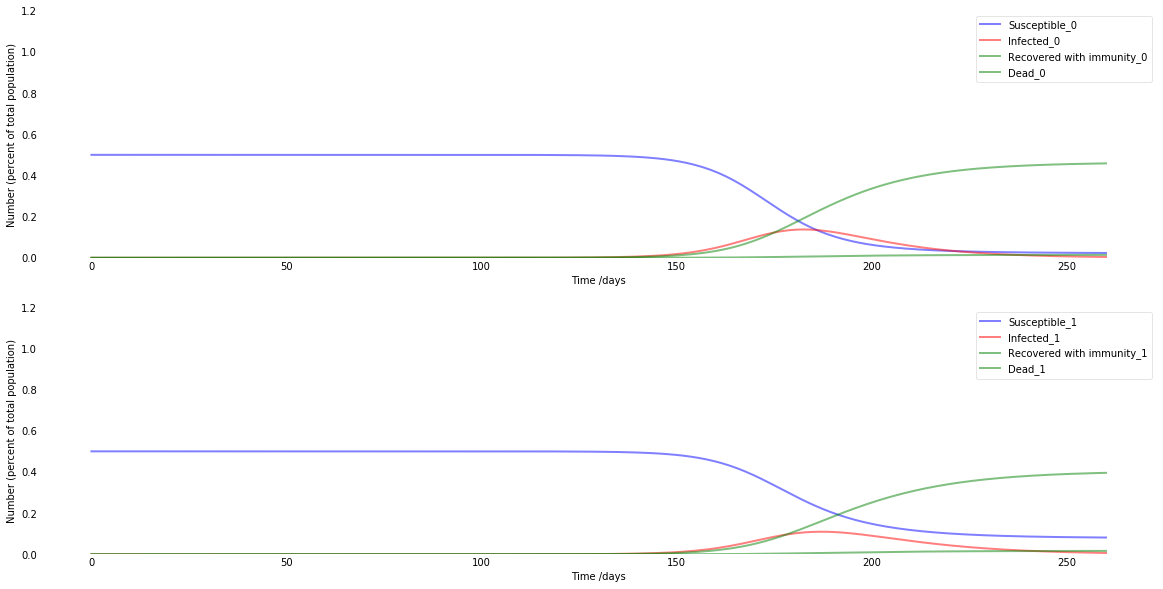

In [50]:

fig = plt.figure(facecolor='w', figsize=(20,10))
ax = fig.add_subplot(111, axisbelow=True)
for i in range(ndim):
    ax = plt.subplot(ndim, 1, i+1)
    ax.plot(sol.t, sol.y[i,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible_{i}')
    ax.plot(sol.t, sol.y[ndim+i,:]/N, 'r', alpha=0.5, lw=2, label=f'Infected_{i}')
    
    ax.plot(sol.t, sol.y[2*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Recovered with immunity_{i}')
    
    ax.plot(sol.t, sol.y[3*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Dead_{i}')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (percent of total population)')
    ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

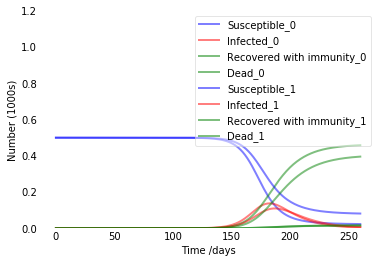

In [51]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, axisbelow=True)
for i in range(ndim):
    ax.plot(sol.t, sol.y[i,:]/N, 'b', alpha=0.5, lw=2, label=f'Susceptible_{i}')
    ax.plot(sol.t, sol.y[ndim+i,:]/N, 'r', alpha=0.5, lw=2, label=f'Infected_{i}')
    
    ax.plot(sol.t, sol.y[2*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Recovered with immunity_{i}')
    
    ax.plot(sol.t, sol.y[3*ndim+i,:]/N, 'g', alpha=0.5, lw=2, label=f'Dead_{i}')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
Enhancements to the simulation:
    - make parameters $\beta, \gamma, \delta$ time dependent as done in the RKI paper
    - solve the system for more than 2 groups 
    - fit the system on actual data (problem is w)